In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GLM_helpers import *
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input

from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture


from allensdk.core.cell_types_cache import CellTypesCache

Using TensorFlow backend.


In [3]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
print A
re_order = np.array([1, 2, 0])
A = A[re_order,:]
A = A[:,re_order]
print A

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[5 6 4]
 [8 9 7]
 [2 3 1]]


In [2]:
from scipy.stats import kurtosis, kurtosistest
x = np.random.normal(size=(10000,))
print kurtosis(x)

0.0106728305039


In [188]:
D = np.load('exc_VISp_5.npz')
F_clump = D['F_clump']
W_clump = D['W_clump']
b_clump = D['b_clump']
loss_clump = D['loss_clump']
d=W_clump.shape[1]
bin_len=0.001
print W_clump.shape
ncomp = 2

W_means = np.empty((ncomp,d))
W_vars = np.empty((ncomp,d))
W_weights = np.empty((ncomp,d))
for i in range(d):
    gm = GaussianMixture(n_components=ncomp,n_init=1)
    gm.fit(np.expand_dims(W_clump[:,i],1))
    order = np.argsort(gm.means_.squeeze())
    W_means[:,i] = gm.means_.squeeze()[order]
    W_vars[:,i] = gm.covariances_.squeeze()[order]
    W_weights[:,i] = gm.weights_.squeeze()[order]
    
F_means = np.empty((ncomp,d))
F_vars = np.empty((ncomp,d))
F_weights = np.empty((ncomp,d))
for i in range(d):
    gm = GaussianMixture(n_components=ncomp,n_init=1)
    gm.fit(np.expand_dims(F_clump[:,i],1))
    order = np.argsort(gm.means_.squeeze())
    F_means[:,i] = gm.means_.squeeze()[order]
    F_vars[:,i] = gm.covariances_.squeeze()[order]
    F_weights[:,i] = gm.weights_.squeeze()[order]


(29, 40)


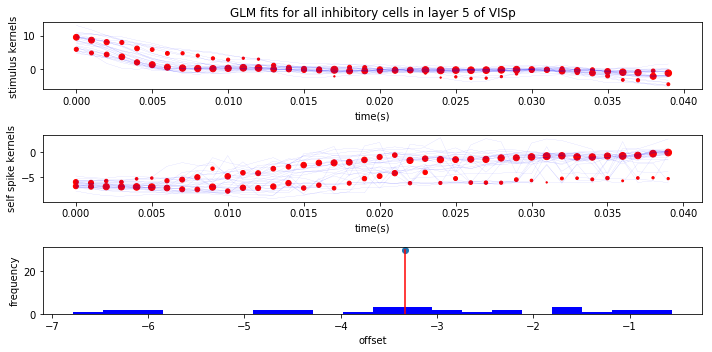

In [189]:
from matplotlib.collections import LineCollection
def plot_thick(x,y,w,color):
    for j in range(y.shape[1]):
        plt.scatter(x,y[:,j],c=color,s=w[:,j])

t = np.arange(d)*bin_len

F_kurts = kurtosis(F_clump,axis = 0)
(z_F,p_F) = kurtosistest(F_clump,axis = 0)
W_kurts = kurtosis(W_clump,axis = 0)
(z_W,p_W) = kurtosistest(W_clump,axis = 0)
b_mean = np.mean(b_clump)
b_std = np.std(b_clump)
b_kurt = kurtosis(b_clump)
(z_b,p_b) = kurtosistest(b_clump)

plt.subplots(3,1,figsize = (10,5))
plt.subplot(3,1,1)
plt.plot(t,F_clump.T,'b',linewidth = 0.1,alpha=0.5)
plot_thick(t,F_means.T,F_weights.T*50,'r')
# plt.plot(t,F_means.T,'r',linewidth = 1)
plt.xlabel('time(s)')
plt.ylabel('stimulus kernels')
plt.title('GLM fits for all inhibitory cells in layer 5 of VISp')

plt.subplot(3,1,2)
plt.plot(t,W_clump.T,'b',linewidth = 0.1,alpha=0.5)
# plt.plot(t,W_means.T,'r',linewidth = 1)
plot_thick(t,W_means.T,W_weights.T*50,'r')
plt.xlabel('time(s)')
plt.ylabel('self spike kernels')

plt.subplot(3,1,3)
plt.hist(b_clump,bins = 20,color='b')
plt.stem([b_mean],[30],'r')
plt.xlabel('offset')
plt.ylabel('frequency')
plt.tight_layout()

# ax[1].xlabel('time(s)')
# ax[0].ylabel('stimulus kernel value')
# ax[1].ylabel('self spike kernel value')
# ax[2].xlabel('offset')
# ax[2].ylabel('frequency')



(138, 15)


(array([ 7.,  9., 16., 13., 19., 16., 19.,  9.,  7.,  5.,  8.,  6.,  2.,
         0.,  2.]),
 array([-2.13392830e+00, -1.92055025e+00, -1.70717220e+00, -1.49379416e+00,
        -1.28041611e+00, -1.06703806e+00, -8.53660011e-01, -6.40281963e-01,
        -4.26903915e-01, -2.13525867e-01, -1.47819519e-04,  2.13230228e-01,
         4.26608276e-01,  6.39986324e-01,  8.53364372e-01,  1.06674242e+00]),
 <a list of 15 Patch objects>)

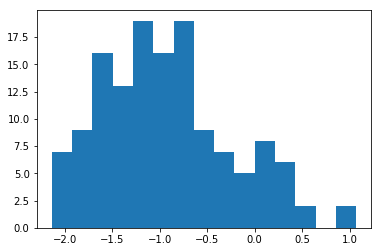

In [84]:
i=5
D = np.load('inh_VISp_2_ftemps.npz')
F_clump = D['F_clump']
W_clump = D['W_clump']
b_clump = D['b_clump']
loss_clump = D['loss_clump']
d=40
bin_len=0.001
print W_clump.shape
plt.hist(W_clump[:,i],bins = 15)

# plt.imshow(np.corrcoef(W_clump.T))
# plt.colorbar()

# R = np.corrcoef(W_clump.T)
# for i in range(R.shape[0]-1):
#     dg = np.diagonal(R,offset=i+1)
#     plt.plot(np.ones(dg.shape)*(i+1), dg,'bo')

40 (40, 15)
[-0.25786427 -0.2725209  -0.161989   -0.17651086 -0.53013939 -0.7032572
 -0.65303898 -0.67417246 -0.52583522 -0.41404304 -0.31661162 -0.68137807
 -0.39879057 -0.65450537 -0.62280399] [-0.71176755]


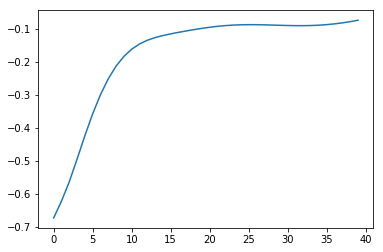

In [48]:
i=7

from scipy.special import gamma
def filt_func(t,a,b):
    return t**(a-1)*np.exp(-b*t)*b**a/gamma(a)

def make_filts(num_filts=15,f_mean_range=(1e-3,0.04),f_var_range=(1e-6,6e-5),dt=1e-3,d=d):
    f_means = np.logspace(np.log10(f_mean_range[0]),np.log10(f_mean_range[1]),num=num_filts)
    f_vars = np.logspace(np.log10(f_var_range[0]),np.log10(f_var_range[1]),num=num_filts)
#    print f_means, f_vars
    f_bs = f_means/f_vars
    f_as = f_means*f_bs
    t = np.arange(1,d+1)*dt
    filts = np.empty((d,num_filts))
    for i in range(num_filts):
        filts[:,i] = filt_func(t,f_as[i],f_bs[i])
        filts[:,i] /= sum(filts[:,i])
#    print np.sum(filts*np.tile(t,(num_filts,1)).T,axis=0)
    return filts


print d, make_filts().shape
print W_clump[i,:], b_clump[i]
plt.plot(W_clump[i,:].dot(make_filts().T))

Text(0,0.5,'Frequency')

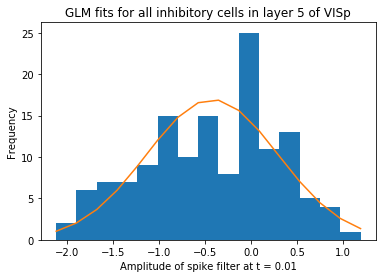

In [96]:
i=10
gm = GaussianMixture(n_components=1,n_init=1)
gm.fit(np.expand_dims(W_clump[:,i],1))

nbins = 15
(_,bins,_) = plt.hist(W_clump[:,i],bins=nbins)
plt.plot(bins,len(W_clump[:,i])*(bins[1]-bins[0])*np.exp(gm.score_samples(bins.reshape(-1, 1))))
plt.title('GLM fits for all inhibitory cells in layer 5 of VISp')
plt.xlabel('Amplitude of spike filter at t = '+str(i*bin_len))
plt.ylabel('Frequency')

In [185]:
import os.path
region = 'VISp'
# f_len = 15
for sign in ['inh', 'exc']:
    for layers in [['1','2/3'],['4'],['5','6a','6b']]:
        F_clump = []
        W_clump = []
        b_clump = []
        loss_clump = []
        for layer in layers:
            if layer == '2/3':
                lname = '2'
            else:
                lname = layer
            fname = sign + '_' + region + '_' + lname + '.npz'
            if os.path.isfile(fname):
                D = np.load(fname)
                F_clump.append(D['F_clump'])
                W_clump.append(D['W_clump'])
                b_clump.append(D['b_clump'])
                loss_clump.append(D['loss_clump'])
                print fname, D['b_clump'].shape
        F_clump = np.vstack(F_clump)
        W_clump = np.vstack(W_clump)
        b_clump = np.vstack(b_clump)
        loss_clump = np.vstack(loss_clump)
        d=W_clump.shape[1]
        bin_len=0.001
        print W_clump.shape
        ncomp = 2

        W_means = np.empty((ncomp,d))
        W_vars = np.empty((ncomp,d))
        W_weights = np.empty((ncomp,d))
        for i in range(d):
            gm = GaussianMixture(n_components=ncomp,n_init=1)
            gm.fit(np.expand_dims(W_clump[:,i],1))
            order = np.argsort(gm.means_.squeeze())
            W_means[:,i] = gm.means_.squeeze()[order]
            W_vars[:,i] = gm.covariances_.squeeze()[order]
            W_weights[:,i] = gm.weights_.squeeze()[order]

        F_means = np.empty((ncomp,d))
        F_vars = np.empty((ncomp,d))
        F_weights = np.empty((ncomp,d))
        for i in range(d):
            gm = GaussianMixture(n_components=ncomp,n_init=1)
            gm.fit(np.expand_dims(F_clump[:,i],1))
            order = np.argsort(gm.means_.squeeze())
            F_means[:,i] = gm.means_.squeeze()[order]
            F_vars[:,i] = gm.covariances_.squeeze()[order]
            F_weights[:,i] = gm.weights_.squeeze()[order]
            
        b_mean = np.mean(b_clump)
        b_std = np.std(b_clump)
        
        np.savez(sign + '_' + region + '_' + layers[0][0]+'GMM_'+str(ncomp)+'comp',W_means=W_means,W_vars=W_vars,W_weights=W_weights,b_mean=b_mean,b_std=b_std)


inh_VISp_1.npz (8, 1)
inh_VISp_2.npz (120, 1)
(128, 40)
inh_VISp_4.npz (108, 1)
(108, 40)
inh_VISp_5.npz (117, 1)
inh_VISp_6a.npz (59, 1)
inh_VISp_6b.npz (9, 1)
(185, 40)
exc_VISp_2.npz (49, 1)
(49, 40)
exc_VISp_4.npz (70, 1)
(70, 40)
exc_VISp_5.npz (29, 1)
(29, 40)


In [99]:
import os.path
region = 'VISp'
# f_len = 15
for sign in ['inh', 'exc']:
    for layers in [['1','2/3'],['4'],['5','6a','6b']]:
        F_clump = []
        W_clump = []
        b_clump = []
        loss_clump = []
        for layer in layers:
            if layer == '2/3':
                lname = '2'
            else:
                lname = layer
            fname = sign + '_' + region + '_' + lname + '_ftemps.npz'
            if os.path.isfile(fname):
                D = np.load(fname)
                F_clump.append(D['F_clump'])
                W_clump.append(D['W_clump'])
                b_clump.append(D['b_clump'])
                loss_clump.append(D['loss_clump'])
                print fname, D['b_clump'].shape
        F_clump = np.vstack(F_clump)
        W_clump = np.vstack(W_clump)
        b_clump = np.vstack(b_clump)
        loss_clump = np.vstack(loss_clump)
#         d=W_clump.shape[1]
        bin_len=0.001
        print W_clump.shape
        ncomp = 1

#         W_means = np.empty((ncomp,d))
#         W_vars = np.empty((ncomp,d))
#         W_weights = np.empty((ncomp,d))
#         for i in range(d):
#             gm = GaussianMixture(n_components=ncomp,n_init=1)
#             gm.fit(np.expand_dims(W_clump[:,i],1))
#             order = np.argsort(gm.means_.squeeze())
#             W_means[:,i] = gm.means_.squeeze()[order]
#             W_vars[:,i] = gm.covariances_.squeeze()[order]
#             W_weights[:,i] = gm.weights_.squeeze()[order]

        W_means = np.mean(W_clump,axis=0)
        W_cov = np.cov(W_clump.T)

#         F_means = np.empty((ncomp,d))
#         F_vars = np.empty((ncomp,d))
#         F_weights = np.empty((ncomp,d))
#         for i in range(d):
#             gm = GaussianMixture(n_components=ncomp,n_init=1)
#             gm.fit(np.expand_dims(F_clump[:,i],1))
#             order = np.argsort(gm.means_.squeeze())
#             F_means[:,i] = gm.means_.squeeze()[order]
#             F_vars[:,i] = gm.covariances_.squeeze()[order]
#             F_weights[:,i] = gm.weights_.squeeze()[order]
            
        b_mean = np.mean(b_clump)
        b_std = np.std(b_clump)
        
        np.savez(sign + '_' + region + '_' + layers[0][0]+'ftempgaus_'+str(ncomp)+'comp',W_means=W_means,W_cov=W_cov,b_mean=b_mean,b_std=b_std)


inh_VISp_1_ftemps.npz (8, 1)
inh_VISp_2_ftemps.npz (138, 1)
(146, 15)
inh_VISp_4_ftemps.npz (108, 1)
(108, 15)
inh_VISp_5_ftemps.npz (165, 1)
inh_VISp_6a_ftemps.npz (59, 1)
inh_VISp_6b_ftemps.npz (9, 1)
(233, 15)
exc_VISp_2_ftemps.npz (49, 1)
(49, 15)
exc_VISp_4_ftemps.npz (239, 1)
(239, 15)
exc_VISp_5_ftemps.npz (148, 1)
exc_VISp_6a_ftemps.npz (55, 1)
exc_VISp_6b_ftemps.npz (2, 1)
(205, 15)


In [187]:
print b_clump.shape

(29, 1)


In [161]:
from scipy.stats import entropy
shift = 0
bins = 20
for i in range(bins-shift):
    pk,_ = np.histogram(np.load('inh_VISp_2.npz')['W_clump'][:,i],bins=bins,range=(-7,3))
    pk = pk + 0.1
    qk,_ = np.histogram(np.load('inh_VISp_4.npz')['W_clump'][:,i+shift],bins=bins,range=(-7,3))
    qk = qk + 0.1

    print entropy(pk,qk=qk)

0.2583743219134119
0.30527967958076596
0.23387966960999387
0.3803610738557188
0.34027380792139417
0.2827920036612316
0.23552256013796863
0.17811022733252088
0.3663617584520163
0.4348728718795975
0.4696041594305564
0.3880718072763988
0.6531719853621212
0.2513814802313625
0.3347570921674705
0.29871669016194735
0.35521807552806833
0.6449703237334101
0.4494169975265696
0.3725903391738975
